<a href="https://colab.research.google.com/github/zlximon/Tensorflow_DL/blob/master/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#downloading helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


--2022-06-08 07:37:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-08 07:37:48 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
#tensorflow datasets
import tensorflow_datasets as tfds

In [3]:
dataset_list=tfds.list_builders()# lits of all tensorflos datasets


tensorflow datasets , are in tensors ready to work with

In [4]:
(train_data,test_data),ds_info=tfds.load("food101",split=["train","validation"],
                                         shuffle_files=True,as_supervised=True,#out data gets returned in tuple format(data,label) for supervised learning  
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete8NT2LD/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete8NT2LD/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
class_names=ds_info.features["label"].names# class names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [6]:
train_sample=train_data.take(1)
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
for image,label in train_sample:
   print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 97
  Class name (str form): takoyaki
  


In [8]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'takoyaki')

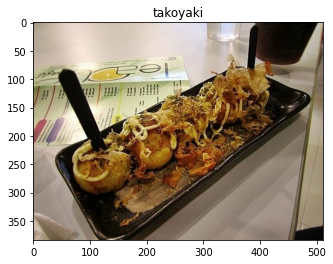

In [9]:
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list


In [10]:
def preprocess_img(image,label,img_shape=224):
  """
  converts image datatype from unit8 to float 32 and reshape image 
  """
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label

In [11]:
preproccesed=preprocess_img(image,label)[0]
print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 97
  Class name (str form): takoyaki
        


#batch and prepare datasets

In [12]:
#map preprocessing for training data
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)#use most of cpu for execute  
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#map preprocessing for test data
test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#creating modelling callback

In [14]:
#create tensorboard 
from helper_functions import create_tensorboard_callback

checkpoint_patch="model_checkpoins/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_patch,monitor="val_acc",save_best_only=True,save_weights_only=True,verbose=0)

#setup mixed precision training




In [15]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")#set global data policy to mixed precision its speeding up our code so much
# the improvement are much noticable on larger models 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


#build feature extraction model

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
input_shape=(224,224,3)
#create base model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False 
#create model
inputs=layers.Input(shape=input_shape ,name="input_layers")
# in EfficientNetB0 Model we dont need rescaling 
x=base_model(inputs,training=False) 
x=layers.GlobalAveragePooling2D()(x)
x= layers.Dense(len(class_names))(x)# number of outputs 
outputs=layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])# out labels are in int form

16719872/16705208 [==============================] - 0s 0us/step


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [18]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layers True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [19]:
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [20]:
#fit the model
history = model.fit(train_data,epochs=3,steps_per_epoch=(len(train_data)),validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                       experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220608-074747
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8190 - accuracy: 0.5592WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 190s 72ms/step - loss: 1.8190 - accuracy: 0.5592 - val_loss: 1.2267 - val_accuracy: 0.6772
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2930 - accuracy: 0.6664WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 172s 72ms/step - loss: 1.2930 - accuracy: 0.6664 - val_loss: 1.1463 - val_accuracy: 0.6925
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1426 - accuracy: 0.7024WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 169s 71ms/step - loss: 1.1426 - accuracy: 0.7024 - val_loss: 1.0790 - val_accuracy: 0.7087


In [21]:
result_feature=model.evaluate(test_data)

790/790 [==============================] - 50s 64ms/step - loss: 1.0884 - accuracy: 0.7053


#fine tune model 

In [25]:
for layer in base_model.layers:# set all layers to trainable 
  layer.trainable=True
#  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [27]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [28]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(0.0001),metrics=["accuracy"])

In [ ]:
history_fin=model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220608-081858
Epoch 1/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9548 - accuracy: 0.7579WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.9548 - accuracy: 0.7579 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9436 - accuracy: 0.7610WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.9436 - accuracy: 0.7610 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9342 - accuracy: 0.7635WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.9342 - accuracy: 0.7635 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9254 - accuracy: 0.7663WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.9254 - accuracy: 0.7663 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9170 - accuracy: 0.7691WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.9170 - accuracy: 0.7691 - lr: 1.0000e-04
Epoch 6/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9090 - accuracy: 0.7706WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.9090 - accuracy: 0.7706 - lr: 1.0000e-04
Epoch 7/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9012 - accuracy: 0.7724WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.9013 - accuracy: 0.7724 - lr: 1.0000e-04
Epoch 8/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8937 - accuracy: 0.7745WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.8937 - accuracy: 0.7745 - lr: 1.0000e-04
Epoch 9/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8865 - accuracy: 0.7760WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 65ms/step - loss: 0.8865 - accuracy: 0.7760 - lr: 1.0000e-04
Epoch 10/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.7781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 155s 65ms/step - loss: 0.8795 - accuracy: 0.7781 - lr: 1.0000e-04
Epoch 11/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8726 - accuracy: 0.7800WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.8727 - accuracy: 0.7800 - lr: 1.0000e-04
Epoch 12/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8661 - accuracy: 0.7819WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 155s 65ms/step - loss: 0.8661 - accuracy: 0.7819 - lr: 1.0000e-04
Epoch 13/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8595 - accuracy: 0.7829WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.8595 - accuracy: 0.7829 - lr: 1.0000e-04
Epoch 14/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8531 - accuracy: 0.7851WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.8531 - accuracy: 0.7851 - lr: 1.0000e-04
Epoch 15/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8471 - accuracy: 0.7862WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.8471 - accuracy: 0.7862 - lr: 1.0000e-04
Epoch 16/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8411 - accuracy: 0.7885WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.8411 - accuracy: 0.7885 - lr: 1.0000e-04
Epoch 17/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8351 - accuracy: 0.7900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 154s 64ms/step - loss: 0.8350 - accuracy: 0.7900 - lr: 1.0000e-04
Epoch 18/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8292 - accuracy: 0.7901WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.8292 - accuracy: 0.7901 - lr: 1.0000e-04
Epoch 19/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8237 - accuracy: 0.7930WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.8237 - accuracy: 0.7930 - lr: 1.0000e-04
Epoch 20/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.7940WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 159s 66ms/step - loss: 0.8181 - accuracy: 0.7940 - lr: 1.0000e-04
Epoch 21/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8129 - accuracy: 0.7955WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.8129 - accuracy: 0.7955 - lr: 1.0000e-04
Epoch 22/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8074 - accuracy: 0.7972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.8074 - accuracy: 0.7972 - lr: 1.0000e-04
Epoch 23/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8025 - accuracy: 0.7981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 65ms/step - loss: 0.8025 - accuracy: 0.7981 - lr: 1.0000e-04
Epoch 24/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7972 - accuracy: 0.7998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.7972 - accuracy: 0.7998 - lr: 1.0000e-04
Epoch 25/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7924 - accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.7924 - accuracy: 0.8010 - lr: 1.0000e-04
Epoch 26/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7876 - accuracy: 0.8018WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 159s 66ms/step - loss: 0.7876 - accuracy: 0.8018 - lr: 1.0000e-04
Epoch 27/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7828 - accuracy: 0.8036WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.7827 - accuracy: 0.8036 - lr: 1.0000e-04
Epoch 28/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7782 - accuracy: 0.8053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.7782 - accuracy: 0.8053 - lr: 1.0000e-04
Epoch 29/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7734 - accuracy: 0.8058WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7734 - accuracy: 0.8058 - lr: 1.0000e-04
Epoch 30/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7689 - accuracy: 0.8075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.7689 - accuracy: 0.8076 - lr: 1.0000e-04
Epoch 31/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7646 - accuracy: 0.8085WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.7647 - accuracy: 0.8085 - lr: 1.0000e-04
Epoch 32/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.8100WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7600 - accuracy: 0.8100 - lr: 1.0000e-04
Epoch 33/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7558 - accuracy: 0.8107WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7558 - accuracy: 0.8107 - lr: 1.0000e-04
Epoch 34/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.8113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 160s 67ms/step - loss: 0.7518 - accuracy: 0.8113 - lr: 1.0000e-04
Epoch 35/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.8129WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7475 - accuracy: 0.8129 - lr: 1.0000e-04
Epoch 36/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7435 - accuracy: 0.8138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7435 - accuracy: 0.8138 - lr: 1.0000e-04
Epoch 37/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.8154WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 65ms/step - loss: 0.7395 - accuracy: 0.8154 - lr: 1.0000e-04
Epoch 38/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7353 - accuracy: 0.8162WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7354 - accuracy: 0.8162 - lr: 1.0000e-04
Epoch 39/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7319 - accuracy: 0.8170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7319 - accuracy: 0.8170 - lr: 1.0000e-04
Epoch 40/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7279 - accuracy: 0.8183WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7279 - accuracy: 0.8183 - lr: 1.0000e-04
Epoch 41/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7239 - accuracy: 0.8194WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 155s 65ms/step - loss: 0.7239 - accuracy: 0.8194 - lr: 1.0000e-04
Epoch 42/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7204 - accuracy: 0.8212WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.7204 - accuracy: 0.8212 - lr: 1.0000e-04
Epoch 43/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.8211WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7166 - accuracy: 0.8211 - lr: 1.0000e-04
Epoch 44/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7130 - accuracy: 0.8230WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 156s 65ms/step - loss: 0.7131 - accuracy: 0.8230 - lr: 1.0000e-04
Epoch 45/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7094 - accuracy: 0.8232WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7095 - accuracy: 0.8232 - lr: 1.0000e-04
Epoch 46/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7060 - accuracy: 0.8247WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.7059 - accuracy: 0.8247 - lr: 1.0000e-04
Epoch 47/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.8248WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.7027 - accuracy: 0.8248 - lr: 1.0000e-04
Epoch 48/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6993 - accuracy: 0.8262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.6993 - accuracy: 0.8262 - lr: 1.0000e-04
Epoch 49/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.8272WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 159s 66ms/step - loss: 0.6959 - accuracy: 0.8272 - lr: 1.0000e-04
Epoch 50/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.8281WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.6924 - accuracy: 0.8281 - lr: 1.0000e-04
Epoch 51/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.8286WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 159s 66ms/step - loss: 0.6893 - accuracy: 0.8286 - lr: 1.0000e-04
Epoch 52/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.8297WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.6862 - accuracy: 0.8297 - lr: 1.0000e-04
Epoch 53/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.8310WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 157s 66ms/step - loss: 0.6830 - accuracy: 0.8310 - lr: 1.0000e-04
Epoch 54/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.8316WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.6799 - accuracy: 0.8315 - lr: 1.0000e-04
Epoch 55/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.8320WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 158s 66ms/step - loss: 0.6768 - accuracy: 0.8320 - lr: 1.0000e-04
Epoch 56/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.8335WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 159s 66ms/step - loss: 0.6738 - accuracy: 0.8335 - lr: 1.0000e-04
Epoch 57/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.8338WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 164s 68ms/step - loss: 0.6708 - accuracy: 0.8338 - lr: 1.0000e-04
Epoch 58/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.8350WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 173s 72ms/step - loss: 0.6677 - accuracy: 0.8350 - lr: 1.0000e-04
Epoch 59/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.8357WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 171s 71ms/step - loss: 0.6648 - accuracy: 0.8358 - lr: 1.0000e-04
Epoch 60/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.8363WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 162s 67ms/step - loss: 0.6619 - accuracy: 0.8364 - lr: 1.0000e-04
Epoch 61/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.8377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 161s 67ms/step - loss: 0.6590 - accuracy: 0.8377 - lr: 1.0000e-04
Epoch 62/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.8382WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 159s 67ms/step - loss: 0.6563 - accuracy: 0.8382 - lr: 1.0000e-04
Epoch 63/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.8385WARNING:tensorflow:Can save best model only with val_loss available, skipping.


2368/2368 [==============================] - 160s 67ms/step - loss: 0.6536 - accuracy: 0.8385 - lr: 1.0000e-04
Epoch 64/100
1943/2368 [=======================>......] - ETA: 28s - loss: 0.6482 - accuracy: 0.8406